# African Wildlife Classification
## By Sergei Issaev

Hello and welcome to my final course project for the 2020 course offering of PyTorch: Zero to GANS, presented by Jovian.ml. I will be attempting to build a classifier capable of taking an input image containing either a buffalo, and elephant, a rhino or a zebra, then outputting the correct class label for the input image. The data was kindly provided by Bianca Ferreira, and can be found here: https://www.kaggle.com/biancaferreira/african-wildlife. 

I will be using the current state-of-the-art performance as a benchmark for my own work. From the five notebooks published for this dataset at the time of this writing, the best accuracy was obtained by Leogalbu, who attained an accuracy of 98.0%. His notebook can be found here:
https://www.kaggle.com/leogalbu/african-wildlife-fastai-progressive-resize.

As per the course instructions, several different methods will be applied to the dataset. They are as follows:
* 1) Logistic Regression
* 2) Feedforward Neural Network
* 3) CNN
* 4) Transfer learning with wide ResNet and data augmentation

The links to the github code, Kaggle notebook, and my social media links are included at the end of the article.


Mapping of animal classes to integers is as follows:

0 -------> buffalo

1 -------> elephant

2 -------> rhino

3 -------> zebra

# Logistic Regression

### Import Libraries

In [1]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import random_split
import torch.nn.functional as F
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(42)

In [2]:
project_name='wildlife'

### Load in the Data

In [3]:
dataset = ImageFolder(root='/kaggle/input/african-wildlife/', transform=transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()]))

In [4]:
dataset_size = len(dataset)
dataset_size

1504

In [5]:
classes = dataset.classes
classes

['buffalo', 'elephant', 'rhino', 'zebra']

In [6]:
num_classes = len(dataset.classes)
num_classes

4

### Perform Train-Validation-Test Split

In [7]:
test_size = 100
nontest_size = len(dataset) - test_size

nontest_ds, test_ds = random_split(dataset, [nontest_size, test_size])
len(nontest_ds), len(test_ds)

(1404, 100)

In [8]:
val_size = 100
train_size = len(nontest_ds) - val_size

train_ds, val_ds = random_split(nontest_ds, [train_size, val_size])
len(train_ds), len(val_ds)

(1304, 100)

In [9]:
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 3, 256, 256])


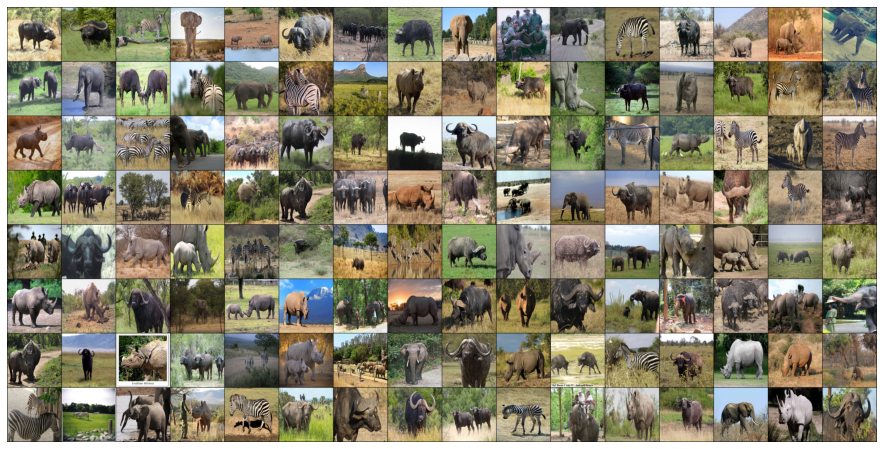

In [10]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [11]:
input_size = 3 * 256*256
num_classes = 4

### Train the Logistic Regression Model

In [12]:
class WildlifeModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1 , 3 * 256 * 256)
        out = self.linear(xb)
        return out
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = WildlifeModel()

In [13]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [15]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [16]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

### Train the model

In [17]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 1.5014777183532715, 'val_acc': 0.20000000298023224}

In [18]:
history1 = fit(50, 0.000005, model, train_loader, val_loader)

Epoch [0], val_loss: 1.4277, val_acc: 0.2100
Epoch [1], val_loss: 1.4033, val_acc: 0.2300
Epoch [2], val_loss: 1.3957, val_acc: 0.2200
Epoch [3], val_loss: 1.3902, val_acc: 0.2800
Epoch [4], val_loss: 1.3867, val_acc: 0.2700
Epoch [5], val_loss: 1.3866, val_acc: 0.2800
Epoch [6], val_loss: 1.3868, val_acc: 0.3000
Epoch [7], val_loss: 1.3828, val_acc: 0.3200
Epoch [8], val_loss: 1.3783, val_acc: 0.3000
Epoch [9], val_loss: 1.3761, val_acc: 0.3200
Epoch [10], val_loss: 1.3729, val_acc: 0.3000
Epoch [11], val_loss: 1.3690, val_acc: 0.2900
Epoch [12], val_loss: 1.3662, val_acc: 0.2900
Epoch [13], val_loss: 1.3622, val_acc: 0.3400
Epoch [14], val_loss: 1.3592, val_acc: 0.3400
Epoch [15], val_loss: 1.3564, val_acc: 0.3300
Epoch [16], val_loss: 1.3573, val_acc: 0.3600
Epoch [17], val_loss: 1.3535, val_acc: 0.3600
Epoch [18], val_loss: 1.3515, val_acc: 0.3400
Epoch [19], val_loss: 1.3495, val_acc: 0.3900
Epoch [20], val_loss: 1.3502, val_acc: 0.3900
Epoch [21], val_loss: 1.3467, val_acc: 0.360

In [19]:
history2 = fit(10, 0.000001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.2964, val_acc: 0.4100
Epoch [1], val_loss: 1.2958, val_acc: 0.4100
Epoch [2], val_loss: 1.2954, val_acc: 0.4100
Epoch [3], val_loss: 1.2953, val_acc: 0.4200
Epoch [4], val_loss: 1.2948, val_acc: 0.4200
Epoch [5], val_loss: 1.2942, val_acc: 0.4200
Epoch [6], val_loss: 1.2940, val_acc: 0.4100
Epoch [7], val_loss: 1.2943, val_acc: 0.4200
Epoch [8], val_loss: 1.2942, val_acc: 0.4200
Epoch [9], val_loss: 1.2938, val_acc: 0.4200


In [20]:
history3 = fit(25, 0.000001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.2933, val_acc: 0.4200
Epoch [1], val_loss: 1.2925, val_acc: 0.4200
Epoch [2], val_loss: 1.2920, val_acc: 0.4100
Epoch [3], val_loss: 1.2914, val_acc: 0.4100
Epoch [4], val_loss: 1.2908, val_acc: 0.4100
Epoch [5], val_loss: 1.2908, val_acc: 0.4100
Epoch [6], val_loss: 1.2908, val_acc: 0.4200
Epoch [7], val_loss: 1.2903, val_acc: 0.4300
Epoch [8], val_loss: 1.2901, val_acc: 0.4100
Epoch [9], val_loss: 1.2901, val_acc: 0.4300
Epoch [10], val_loss: 1.2901, val_acc: 0.4200
Epoch [11], val_loss: 1.2901, val_acc: 0.4300
Epoch [12], val_loss: 1.2900, val_acc: 0.4200
Epoch [13], val_loss: 1.2898, val_acc: 0.4200
Epoch [14], val_loss: 1.2894, val_acc: 0.4100
Epoch [15], val_loss: 1.2891, val_acc: 0.4100
Epoch [16], val_loss: 1.2887, val_acc: 0.4200
Epoch [17], val_loss: 1.2887, val_acc: 0.4200
Epoch [18], val_loss: 1.2886, val_acc: 0.4300
Epoch [19], val_loss: 1.2883, val_acc: 0.4300
Epoch [20], val_loss: 1.2884, val_acc: 0.4200
Epoch [21], val_loss: 1.2880, val_acc: 0.420

In [21]:
history4 = fit(10, 0.0000005, model, train_loader, val_loader)

Epoch [0], val_loss: 1.2877, val_acc: 0.4500
Epoch [1], val_loss: 1.2873, val_acc: 0.4500
Epoch [2], val_loss: 1.2874, val_acc: 0.4500
Epoch [3], val_loss: 1.2870, val_acc: 0.4400
Epoch [4], val_loss: 1.2871, val_acc: 0.4500
Epoch [5], val_loss: 1.2871, val_acc: 0.4500
Epoch [6], val_loss: 1.2870, val_acc: 0.4500
Epoch [7], val_loss: 1.2869, val_acc: 0.4500
Epoch [8], val_loss: 1.2867, val_acc: 0.4500
Epoch [9], val_loss: 1.2867, val_acc: 0.4600


In [22]:
history5 = fit(10, 0.0000005, model, train_loader, val_loader)

Epoch [0], val_loss: 1.2861, val_acc: 0.4600
Epoch [1], val_loss: 1.2857, val_acc: 0.4500
Epoch [2], val_loss: 1.2856, val_acc: 0.4600
Epoch [3], val_loss: 1.2857, val_acc: 0.4500
Epoch [4], val_loss: 1.2854, val_acc: 0.4500
Epoch [5], val_loss: 1.2851, val_acc: 0.4300
Epoch [6], val_loss: 1.2848, val_acc: 0.4300
Epoch [7], val_loss: 1.2846, val_acc: 0.4300
Epoch [8], val_loss: 1.2845, val_acc: 0.4400
Epoch [9], val_loss: 1.2843, val_acc: 0.4500


In [23]:
history6 = fit(10, 0.0000005, model, train_loader, val_loader)

Epoch [0], val_loss: 1.2840, val_acc: 0.4300
Epoch [1], val_loss: 1.2839, val_acc: 0.4400
Epoch [2], val_loss: 1.2839, val_acc: 0.4400
Epoch [3], val_loss: 1.2838, val_acc: 0.4500
Epoch [4], val_loss: 1.2837, val_acc: 0.4500
Epoch [5], val_loss: 1.2836, val_acc: 0.4500
Epoch [6], val_loss: 1.2836, val_acc: 0.4500
Epoch [7], val_loss: 1.2834, val_acc: 0.4500
Epoch [8], val_loss: 1.2832, val_acc: 0.4500
Epoch [9], val_loss: 1.2833, val_acc: 0.4400


The validation accuracy from the tuned Logistic Regression model was 44.0%. Considering there are only 4 classes, and guessing randomly would get about 25% accuracy, this isn't great. Let's try a feedforward neural network.

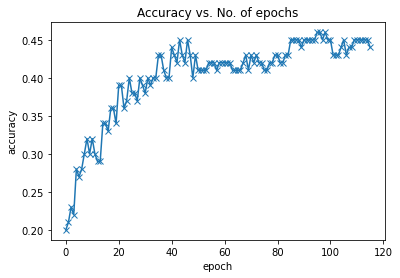

In [24]:
# Replace these values with your results
history = [result0] + history1 + history2 + history3 + history4 + history5 + history6
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [25]:
!pip install jovian

     |████████████████████████████████| 63 kB 1.3 MB/s eta 0:00:011
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6500 sha256=3bb2ed057be6f074a00e61e22504ed7e54aac560978d3271e1626161f3cdaee9
  Stored in directory: /root/.cache/pip/wheels/2a/ea/87/dd57f1ecb4f0752f3e1dbf958ebf8b36d920d190425bcdc24d
Successfully built uuid


In [26]:
import jovian

<IPython.core.display.Javascript object>

In [28]:
jovian.log_metrics(val_acc=history[-1]['val_acc'], val_loss=history[-1]['val_loss'])

[jovian] Metrics logged.


In [27]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/sergeiissaev/wildlife


<IPython.core.display.Javascript object>

# Feedforward Neural Network

Since we have already done the imports and dataloaders, we won't repeat them here, and will go straight to defining and training the feedforward neural network.

In [29]:
input_size = 3 * 256 * 256
hidden_size1 = 128 # you can change this
hidden_size2 = 32
hidden_size3 = 64
hidden_size4 = 32
output_size = 4

In [30]:
class FeedforwardModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size1)
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, hidden_size3)
        self.linear4 = nn.Linear(hidden_size3, hidden_size4)
        self.linear5 = nn.Linear(hidden_size4, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [31]:
model = FeedforwardModel()

In [32]:
for t in model.parameters():
    print(t.shape)

torch.Size([128, 196608])
torch.Size([128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([64, 32])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([4, 32])
torch.Size([4])


In [33]:
torch.cuda.is_available()

True

In [34]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [35]:
device = get_default_device()
device

device(type='cuda')

In [36]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [37]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 3, 256, 256])
cuda:0


In [38]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [39]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [40]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([3, 2, 3, 1, 1, 2, 1, 2, 0, 2, 1, 3, 2, 1, 1, 2, 2, 2, 0, 3, 3, 0, 1, 3,
        1, 3, 3, 2, 3, 0, 0, 1, 1, 2, 3, 2, 3, 1, 0, 2, 3, 2, 1, 2, 1, 2, 2, 0,
        0, 0, 1, 3, 3, 1, 2, 3, 0, 1, 3, 2, 3, 3, 2, 0, 1, 1, 0, 2, 1, 1, 0, 2,
        1, 0, 1, 0, 2, 2, 0, 0, 2, 1, 2, 3, 3, 0, 2, 2, 2, 3, 3, 2, 0, 2, 0, 3,
        2, 1, 0, 2], device='cuda:0')


In [41]:
# Model (on GPU)
model = FeedforwardModel()
to_device(model, device)

FeedforwardModel(
  (linear1): Linear(in_features=196608, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=32, bias=True)
  (linear5): Linear(in_features=32, out_features=4, bias=True)
)

In [42]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 1.3845736980438232, 'val_acc': 0.23000000417232513}]

In [43]:
history += fit(30, 0.01000, model, train_loader, val_loader)

Epoch [0], val_loss: 1.3794, val_acc: 0.3000
Epoch [1], val_loss: 1.3816, val_acc: 0.2400
Epoch [2], val_loss: 1.3733, val_acc: 0.3100
Epoch [3], val_loss: 1.3690, val_acc: 0.3100
Epoch [4], val_loss: 1.3556, val_acc: 0.4600
Epoch [5], val_loss: 1.3778, val_acc: 0.2500
Epoch [6], val_loss: 1.3414, val_acc: 0.3600
Epoch [7], val_loss: 1.3466, val_acc: 0.3500
Epoch [8], val_loss: 1.3105, val_acc: 0.4500
Epoch [9], val_loss: 1.3116, val_acc: 0.4500
Epoch [10], val_loss: 1.2977, val_acc: 0.3900
Epoch [11], val_loss: 1.2789, val_acc: 0.3900
Epoch [12], val_loss: 1.3921, val_acc: 0.2500
Epoch [13], val_loss: 1.2450, val_acc: 0.4100
Epoch [14], val_loss: 1.3325, val_acc: 0.3100
Epoch [15], val_loss: 1.5538, val_acc: 0.2100
Epoch [16], val_loss: 1.2169, val_acc: 0.4300
Epoch [17], val_loss: 1.2916, val_acc: 0.3500
Epoch [18], val_loss: 1.1844, val_acc: 0.4500
Epoch [19], val_loss: 1.1740, val_acc: 0.5100
Epoch [20], val_loss: 1.2781, val_acc: 0.4200
Epoch [21], val_loss: 1.2647, val_acc: 0.380

In [44]:
history += fit(30, 0.00500, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1636, val_acc: 0.4400
Epoch [1], val_loss: 1.1052, val_acc: 0.5500
Epoch [2], val_loss: 1.1315, val_acc: 0.4400
Epoch [3], val_loss: 1.1068, val_acc: 0.5300
Epoch [4], val_loss: 1.1011, val_acc: 0.5200
Epoch [5], val_loss: 1.1068, val_acc: 0.5300
Epoch [6], val_loss: 1.2000, val_acc: 0.5100
Epoch [7], val_loss: 1.1031, val_acc: 0.5100
Epoch [8], val_loss: 1.1353, val_acc: 0.4600
Epoch [9], val_loss: 1.1541, val_acc: 0.4700
Epoch [10], val_loss: 1.1001, val_acc: 0.5500
Epoch [11], val_loss: 1.1513, val_acc: 0.5100
Epoch [12], val_loss: 1.0781, val_acc: 0.5300
Epoch [13], val_loss: 1.1683, val_acc: 0.4500
Epoch [14], val_loss: 1.2372, val_acc: 0.4500
Epoch [15], val_loss: 1.0694, val_acc: 0.5800
Epoch [16], val_loss: 1.3047, val_acc: 0.4100
Epoch [17], val_loss: 1.0992, val_acc: 0.5200
Epoch [18], val_loss: 1.1511, val_acc: 0.5100
Epoch [19], val_loss: 1.1886, val_acc: 0.4600
Epoch [20], val_loss: 1.1363, val_acc: 0.5400
Epoch [21], val_loss: 1.1161, val_acc: 0.530

In [45]:
history += fit(30, 0.00010, model, train_loader, val_loader)

Epoch [0], val_loss: 1.0993, val_acc: 0.5300
Epoch [1], val_loss: 1.0779, val_acc: 0.5300
Epoch [2], val_loss: 1.0706, val_acc: 0.5000
Epoch [3], val_loss: 1.0700, val_acc: 0.4800
Epoch [4], val_loss: 1.0739, val_acc: 0.5200
Epoch [5], val_loss: 1.0770, val_acc: 0.5200
Epoch [6], val_loss: 1.0795, val_acc: 0.5200
Epoch [7], val_loss: 1.0832, val_acc: 0.5200
Epoch [8], val_loss: 1.0846, val_acc: 0.5200
Epoch [9], val_loss: 1.0850, val_acc: 0.5200
Epoch [10], val_loss: 1.0857, val_acc: 0.5200
Epoch [11], val_loss: 1.0878, val_acc: 0.5200
Epoch [12], val_loss: 1.0870, val_acc: 0.5200
Epoch [13], val_loss: 1.0868, val_acc: 0.5200
Epoch [14], val_loss: 1.0864, val_acc: 0.5200
Epoch [15], val_loss: 1.0840, val_acc: 0.5200
Epoch [16], val_loss: 1.0854, val_acc: 0.5200
Epoch [17], val_loss: 1.0835, val_acc: 0.5200
Epoch [18], val_loss: 1.0852, val_acc: 0.5200
Epoch [19], val_loss: 1.0867, val_acc: 0.5200
Epoch [20], val_loss: 1.0863, val_acc: 0.5200
Epoch [21], val_loss: 1.0863, val_acc: 0.520

In [46]:
history += fit(30, 0.00005, model, train_loader, val_loader)

Epoch [0], val_loss: 1.0852, val_acc: 0.5200
Epoch [1], val_loss: 1.0859, val_acc: 0.5200
Epoch [2], val_loss: 1.0877, val_acc: 0.5200
Epoch [3], val_loss: 1.0881, val_acc: 0.5200
Epoch [4], val_loss: 1.0880, val_acc: 0.5200
Epoch [5], val_loss: 1.0888, val_acc: 0.5200
Epoch [6], val_loss: 1.0884, val_acc: 0.5200
Epoch [7], val_loss: 1.0891, val_acc: 0.5200
Epoch [8], val_loss: 1.0885, val_acc: 0.5200
Epoch [9], val_loss: 1.0876, val_acc: 0.5200
Epoch [10], val_loss: 1.0886, val_acc: 0.5200
Epoch [11], val_loss: 1.0884, val_acc: 0.5200
Epoch [12], val_loss: 1.0878, val_acc: 0.5200
Epoch [13], val_loss: 1.0877, val_acc: 0.5200
Epoch [14], val_loss: 1.0874, val_acc: 0.5200
Epoch [15], val_loss: 1.0876, val_acc: 0.5200
Epoch [16], val_loss: 1.0877, val_acc: 0.5200
Epoch [17], val_loss: 1.0866, val_acc: 0.5200
Epoch [18], val_loss: 1.0868, val_acc: 0.5200
Epoch [19], val_loss: 1.0870, val_acc: 0.5200
Epoch [20], val_loss: 1.0864, val_acc: 0.5200
Epoch [21], val_loss: 1.0860, val_acc: 0.520

The validation accuracy from the tuned feedforward neural network model was 52.0%. This is an improvement, however it is still far below the baseline. Let's try using a convolutional neural network, which is known to do well with image data.

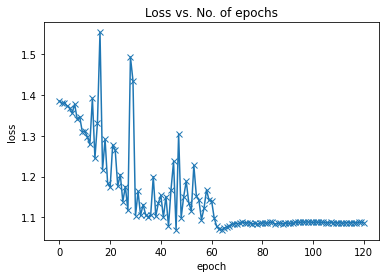

In [47]:
plot_losses(history)

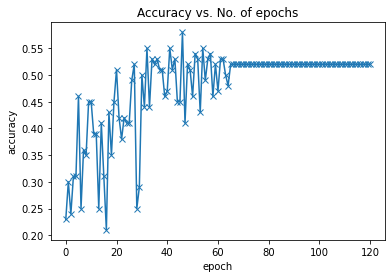

In [48]:
plot_accuracies(history)

In [49]:
jovian.log_metrics(val_acc=history[-1]['val_acc'], val_loss=history[-1]['val_loss'])

[jovian] Metrics logged.


In [50]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sergeiissaev/wildlife


<IPython.core.display.Javascript object>

# CNN

These old school methods did not perform very well for image classification. Let's try using some CNNs!

In [51]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import random_split
import torch.nn.functional as F
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(42)

In [54]:
dataset = ImageFolder(root='/kaggle/input/african-wildlife', transform=transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()]))

In [55]:
dataset_size = len(dataset)
dataset_size

1504

In [56]:
classes = dataset.classes
classes

['buffalo', 'elephant', 'rhino', 'zebra']

In [57]:
num_classes = len(dataset.classes)
num_classes

4

### Perform Train-Validation-Test Split

In [58]:
test_size = 100
nontest_size = len(dataset) - test_size

nontest_ds, test_ds = random_split(dataset, [nontest_size, test_size])
len(nontest_ds), len(test_ds)

(1404, 100)

In [59]:
val_size = 100
train_size = len(nontest_ds) - val_size

train_ds, val_ds = random_split(nontest_ds, [train_size, val_size])
len(train_ds), len(val_ds)

(1304, 100)

In [60]:
batch_size = 16

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

In [61]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [62]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [63]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*16*16 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [64]:
model = CnnModel()
model

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=262144, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, out_features=512,

In [65]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [66]:
device = get_default_device()
device

device(type='cuda')

In [67]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [68]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [70]:
model = to_device(CnnModel(), device)

for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([16, 3, 256, 256])
out.shape: torch.Size([16, 10])
out[0]: tensor([-0.0350,  0.0202,  0.0435,  0.0049,  0.0422,  0.0276, -0.0370, -0.0089,
         0.0287, -0.0059], device='cuda:0', grad_fn=<SelectBackward>)


In [71]:
num_epochs1 = 10
num_epochs2 = 10
num_epochs3 = 10
opt_func = torch.optim.Adam
lr1 = 0.000010
lr2 = 0.0000005
lr3 = 0.0000001


evaluate(model, val_dl)

{'val_loss': 2.297260284423828, 'val_acc': 0.359375}

In [72]:
history = fit(num_epochs1, lr1, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.7486, val_loss: 1.3879, val_acc: 0.1797
Epoch [1], train_loss: 1.3811, val_loss: 1.3471, val_acc: 0.3125
Epoch [2], train_loss: 1.2505, val_loss: 1.2210, val_acc: 0.4453
Epoch [3], train_loss: 1.1109, val_loss: 1.1232, val_acc: 0.4844
Epoch [4], train_loss: 1.0397, val_loss: 1.0205, val_acc: 0.4531
Epoch [5], train_loss: 1.0170, val_loss: 1.0472, val_acc: 0.4766
Epoch [6], train_loss: 0.9743, val_loss: 1.0179, val_acc: 0.4766
Epoch [7], train_loss: 0.9316, val_loss: 1.0504, val_acc: 0.5156
Epoch [8], train_loss: 0.9118, val_loss: 0.9989, val_acc: 0.5078
Epoch [9], train_loss: 0.8893, val_loss: 1.0012, val_acc: 0.5234


In [73]:
history = fit(num_epochs2, lr2, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.8604, val_loss: 0.9629, val_acc: 0.5391
Epoch [1], train_loss: 0.8483, val_loss: 0.9587, val_acc: 0.5391
Epoch [2], train_loss: 0.8487, val_loss: 0.9593, val_acc: 0.5391
Epoch [3], train_loss: 0.8418, val_loss: 0.9609, val_acc: 0.5312
Epoch [4], train_loss: 0.8415, val_loss: 0.9627, val_acc: 0.5234
Epoch [5], train_loss: 0.8404, val_loss: 0.9542, val_acc: 0.5469
Epoch [6], train_loss: 0.8386, val_loss: 0.9677, val_acc: 0.5312
Epoch [7], train_loss: 0.8374, val_loss: 0.9573, val_acc: 0.5312
Epoch [8], train_loss: 0.8406, val_loss: 0.9704, val_acc: 0.5312
Epoch [9], train_loss: 0.8363, val_loss: 0.9545, val_acc: 0.5469


In [74]:
history = fit(num_epochs3, lr3, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.8319, val_loss: 0.9557, val_acc: 0.5312
Epoch [1], train_loss: 0.8370, val_loss: 0.9576, val_acc: 0.5312
Epoch [2], train_loss: 0.8366, val_loss: 0.9589, val_acc: 0.5312
Epoch [3], train_loss: 0.8312, val_loss: 0.9579, val_acc: 0.5312
Epoch [4], train_loss: 0.8328, val_loss: 0.9589, val_acc: 0.5312
Epoch [5], train_loss: 0.8334, val_loss: 0.9586, val_acc: 0.5312
Epoch [6], train_loss: 0.8303, val_loss: 0.9589, val_acc: 0.5312
Epoch [7], train_loss: 0.8328, val_loss: 0.9580, val_acc: 0.5312
Epoch [8], train_loss: 0.8301, val_loss: 0.9584, val_acc: 0.5312
Epoch [9], train_loss: 0.8310, val_loss: 0.9586, val_acc: 0.5312


The validation accuracy for this CNN was 53.12%. Not a great improvement. Perhaps using a larger network, such as ResNet, can help us achieve our goal. Note that we will be using data augmentation now as well.

In [75]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

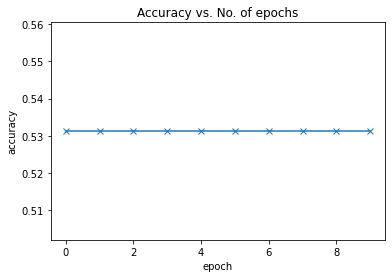

In [76]:
plot_accuracies(history)

In [77]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

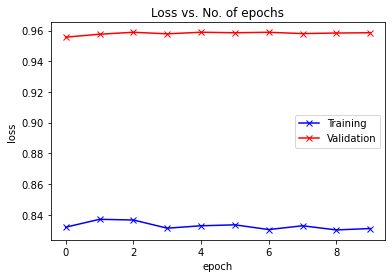

In [78]:
plot_losses(history)

In [79]:
jovian.log_metrics(val_acc=history[-1]['val_acc'], val_loss=history[-1]['val_loss'])

[jovian] Metrics logged.


In [80]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sergeiissaev/wildlife


<IPython.core.display.Javascript object>


### Resnet

Let's try transfer learning from wide_resnet.

In [81]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
from tqdm.notebook import tqdm
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import PIL

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

In [82]:
dataset = ImageFolder(root='/kaggle/input/african-wildlife/')

dataset_size = len(dataset)
dataset_size

1504

In [83]:
classes = dataset.classes
classes

['buffalo', 'elephant', 'rhino', 'zebra']

In [84]:
num_classes = len(dataset.classes)
num_classes

4

### Perform Train-Validation-Test Split

In [85]:
test_size = 100
nontest_size = len(dataset) - test_size

nontest_df, test_df = random_split(dataset, [nontest_size, test_size])
len(nontest_df), len(test_df)

(1404, 100)

In [86]:
val_size = 100
train_size = len(nontest_df) - val_size

train_df, val_df = random_split(nontest_df, [train_size, val_size])
len(train_df), len(val_df)

(1304, 100)

In [87]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_tfms = T.Compose([
    #T.RandomCrop(256, padding=8, padding_mode='reflect'),
     #T.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
    #T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(), 
    T.RandomRotation(10),
    T.ToTensor(), 
     T.Normalize(*imagenet_stats,inplace=True), 
    #T.RandomErasing(inplace=True)
])

valid_tfms = T.Compose([
     T.Resize((256, 256)), 
    T.ToTensor(), 
     T.Normalize(*imagenet_stats)
])

In [88]:
test_df.dataset.transform = valid_tfms
val_df.dataset.transform = valid_tfms

train_df.dataset.transform = train_tfms

In [89]:
batch_size = 16

train_dl = DataLoader(train_df, batch_size, shuffle=True, 
                      num_workers=3, pin_memory=True)
val_dl = DataLoader(val_df, batch_size*2, 
                    num_workers=2, pin_memory=True)
test_dl = DataLoader(test_df, batch_size*2, 
                    num_workers=2, pin_memory=True)

In [90]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [91]:
class CnnModel2(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.wide_resnet101_2(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 4)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))


# In[40]:


model = CnnModel2()
model


Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/checkpoints/wide_resnet101_2-32ee1156.pth


CnnModel2(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [92]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


# In[42]:


device = get_default_device()
device

device(type='cuda')

In [93]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device);

In [94]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [109]:
model = to_device(CnnModel2(), device)

for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([16, 3, 256, 256])
out.shape: torch.Size([16, 4])
out[0]: tensor([0.5241, 0.4795, 0.5673, 0.4425], device='cuda:0',
       grad_fn=<SelectBackward>)


In [110]:
num_epochs1 = 10
opt_func = torch.optim.Adam
lr1 = 0.000010

evaluate(model, val_dl)

{'val_loss': 1.4141544103622437, 'val_acc': 0.2734375}

In [111]:
history = fit(num_epochs1, lr1, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.2608, val_loss: 1.0559, val_acc: 0.9766
Epoch [1], train_loss: 0.9684, val_loss: 0.8807, val_acc: 0.9844
Epoch [2], train_loss: 0.8615, val_loss: 0.8290, val_acc: 0.9844
Epoch [3], train_loss: 0.8154, val_loss: 0.8113, val_acc: 0.9688
Epoch [4], train_loss: 0.7985, val_loss: 0.7945, val_acc: 0.9844
Epoch [5], train_loss: 0.7845, val_loss: 0.7848, val_acc: 0.9844
Epoch [6], train_loss: 0.7766, val_loss: 0.7825, val_acc: 0.9844
Epoch [7], train_loss: 0.7795, val_loss: 0.7769, val_acc: 0.9844
Epoch [8], train_loss: 0.7698, val_loss: 0.7750, val_acc: 0.9844
Epoch [9], train_loss: 0.7694, val_loss: 0.7727, val_acc: 0.9844


Interesting... the model no longer fits at 100% accuracy, even though it did when I ran the code on another server:
![](http://i.ibb.co/TWLfJKy/lavie.png)
This was most likely caused by a lucky start to the gradient descent, that let it find a nice minimum. Restarting the training several times will likely find it again. Let this be a lesson to save your model weights when you get a record breaking score! Live and learn, c'est la vie :'(

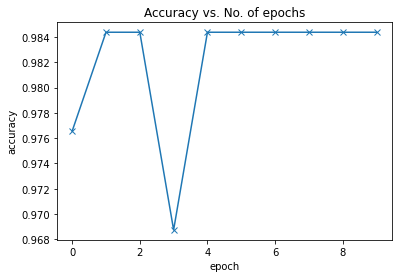

In [112]:
plot_accuracies(history)

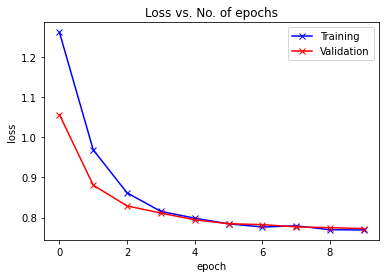

In [113]:
plot_losses(history)

In [114]:
jovian.log_metrics(val_acc=history[-1]['val_acc'], val_loss=history[-1]['val_loss'])

[jovian] Metrics logged.


In [115]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sergeiissaev/wildlife


<IPython.core.display.Javascript object>

EDIT: I reran the code on my other server, and was able to save the weights for the 100% accuracy model. I couldn't get 100% on the kaggle server (guess it doesn't have the magic touch that Compute Canada's Helios server does), and since I can already see the sun rising loading in the weights will have to do.

In [116]:
model2 = CnnModel2()
model2.load_state_dict(torch.load('/kaggle/input/weights100/weights1.pth'))
model2.state_dict()

OrderedDict([('network.conv1.weight',
              tensor([[[[ 2.0293e-03, -9.4950e-03, -1.1554e-02,  ...,  6.9810e-02,
                         -2.5204e-02, -2.8664e-02],
                        [-1.0870e-05, -6.0994e-02, -4.8947e-02,  ...,  1.6109e-01,
                         -6.6155e-02, -1.0096e-01],
                        [-2.1621e-03, -1.0320e-01, -9.0362e-02,  ...,  2.3218e-01,
                         -1.1554e-01, -1.5468e-01],
                        ...,
                        [-1.2056e-03, -1.0428e-01, -9.2737e-02,  ...,  2.0080e-01,
                         -9.8820e-02, -1.3248e-01],
                        [ 4.7665e-03, -5.5942e-02, -4.5377e-02,  ...,  1.2576e-01,
                         -5.2149e-02, -5.2861e-02],
                        [ 1.6508e-02, -2.3631e-03, -1.1211e-02,  ...,  5.3727e-02,
                         -2.4024e-02,  3.8421e-03]],
              
                       [[-1.2605e-04, -1.6939e-02, -3.3932e-03,  ...,  7.6785e-02,
                        

In [117]:
model2 = to_device(model2, device)

In [118]:
evaluate(model2, val_dl)

{'val_loss': 0.7561163306236267, 'val_acc': 1.0}

In [119]:
evaluate(model2, test_dl)

{'val_loss': 0.7541824579238892, 'val_acc': 1.0}

In [120]:
jovian.log_metrics(val_acc=history[-1]['val_acc'], val_loss=history[-1]['val_loss'])

[jovian] Metrics logged.


In [121]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sergeiissaev/wildlife


<IPython.core.display.Javascript object>

![](http://www.memekingz.net/img/memes/201805/aceb324e10bb797ec061881347548226.jpg)

# Final Remarks

We have reached 100% accuracy in not only the validation set, but in the test set as well! Therefore, I have surpassed the previous state of the art (98%), and have built a classifier that can be relied upon for classifying the four African animals. This can have further applications in preventing the poaching of endangered species, and can be of interest to conservations groups and other wildlife researchers.

Of course, this notebook is considerably longer than the previous state-of-the-art, which was created using Fast.AI, a framework built on PyTorch that can create models in a fraction of the number of lines of code used for this notebook. Is the extra time and energy worth a 2% increase in model accuracy? That's up to you to decide ;) 

Thank you for reading until the end! If you have any questions or comments either leave them below the kernel or reach out to me at sergei740@gmail.com. 

![](http://memegenerator.net/img/instances/66006142/thank-you-for-reading-this-article.jpg)